## IMDB Movie Review Sentiment Analysis with EDA, Feature Engineering, and ML

This notebook implements a comprehensive sentiment analysis pipeline covering:
- Data Loading & Preprocessing, First EDA, Feature Engineering, Second EDA & Statistical Inference, Machine Learning, Presentation & Reflection

### Dataset
- **Source**: IMDB Movie Reviews Dataset - https://www.kaggle.com/datasets/mahmoudshaheen1134/imdp-data
- **Location**: `../dataset/IMDB-Dataset.csv`
### Authors
- **Students**: Ainedembe Denis, Musinguzi Benson
- **Lecturer**: Harriet Sibitenda (PhD)


### Import Required Libraries


In [34]:
# DATA MANIPULATION AND ANALYSIS
import pandas as pd  # Data manipulation and analysis: DataFrames, data loading, cleaning
import numpy as np   # Numerical computing: arrays, mathematical operations, random number generation

# VISUALIZATION
import matplotlib.pyplot as plt   # Plotting library: create charts, graphs, histograms
import seaborn as sns             # Statistical visualization: enhanced plots, heatmaps, statistical graphics
from wordcloud import WordCloud   # Word cloud generation: visualize most frequent words in text

# MACHINE LEARNING - MODEL SELECTION AND TRAINING
from sklearn.model_selection import train_test_split  # Split data into training and testing sets
from sklearn.model_selection import KFold             # K-fold cross-validation iterator

# MACHINE LEARNING - FEATURE EXTRACTION
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert text to TF-IDF features (term frequency-inverse document frequency)
from sklearn.feature_extraction.text import CountVectorizer  # Convert text to bag-of-words count features
from collections import Counter                              # Count occurrences of elements in iterable i.e used for word frequency

# MACHINE LEARNING - CLASSIFICATION MODELS
from sklearn.naive_bayes import MultinomialNB               # Naive Bayes classifier for text classification
from sklearn.linear_model import LogisticRegression         # Logistic regression classifier
from sklearn.svm import LinearSVC                           # Linear Support Vector Machine classifier
from sklearn.ensemble import GradientBoostingClassifier     # Gradient Boosting ensemble classifier

# MACHINE LEARNING - MODEL EVALUATION METRICS
from sklearn.metrics import accuracy_score      # Calculate classification accuracy
from sklearn.metrics import precision_score     # Calculate precision - positive predictive value
from sklearn.metrics import recall_score        # Calculate recall (sensitivity, true positive rate)
from sklearn.metrics import f1_score            # Calculate F1 score (harmonic mean of precision and recall)
from sklearn.metrics import confusion_matrix    # Generate confusion matrix for classification results
from sklearn.metrics import roc_auc_score       # Calculate ROC-AUC (Area Under ROC Curve)

# MACHINE LEARNING - UTILITIES
from sklearn.utils import resample                      # Resample datasets for balancing classes
from sklearn.preprocessing import MinMaxScaler          # Scale features to a specific range (0-1)
from sklearn.base import clone                          # Clone/copy machine learning models
from sklearn.calibration import CalibratedClassifierCV  # Calibrate classifier probabilities

# STATISTICAL ANALYSIS
from scipy import stats               # Statistical functions: distributions, statistical tests (stats.sem, stats.t.ppf)
from scipy.stats import ttest_ind     # Independent samples t-test for hypothesis testing

# NATURAL LANGUAGE PROCESSING
import nltk                                    # Natural Language Toolkit: NLP library
from nltk.corpus import stopwords              # Common stopwords (e.g., "the", "a", "is") to filter out
import re                                      # Regular expressions: pattern matching for text cleaning (HTML removal, punctuation)

# NLTK DATA DOWNLOAD AND INITIALIZATION
# Download stopwords corpus
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

# Initialize stopwords set for English language
stop_words = set(stopwords.words('english'))

# REPRODUCIBILITY SETTINGS
# Set random seed for reproducibility ensuring consistent results across runs
np.random.seed(42)

# DISPLAY SETTINGS
# Configure pandas display options
pd.set_option('display.max_columns', None)      # Show all columns when printing DataFrames
pd.set_option('display.max_colwidth', 100)      # Maximum column width when displaying text

# Configure matplotlib and seaborn visualization styles
plt.style.use('seaborn-v0_8')                   # Use seaborn style for plots
sns.set_palette("husl")                         # Set color palette for seaborn plots
# Display plots inline in Jupyter notebook
%matplotlib inline                              

print("Libraries imported and environment set up successfully.")
print(f"NLTK data ready. Loaded {len(stop_words)} stopwords.")

Libraries imported and environment set up successfully.
NLTK data ready. Loaded 198 stopwords.


### Part A: Data Loading & Preprocessing

#### A1. Load Dataset


In [35]:
# Load dataset from CSV file
# The dataset contains movie reviews and their sentiment labels
df = pd.read_csv('../dataset/IMDB-Dataset.csv')

print(f"Dataset shape: {df.shape}")
df.head()  # Display first few rows to inspect the data structure


Dataset shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive


In [36]:
# Check data quality
msing_vl = df.isnull().sum().sum()
print(f"Missing values: {msing_vl}")


Missing values: 0


### A2. Text Cleaning

Removing HTML tags, Converting to lowercase, Removing punctuation & Tokenizing


In [37]:
# Sample review before cleaning
print("Sample review of first 300 characters:")
print(df['review'].iloc[0][:300])
print("\n")


Sample review of first 300 characters:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru




In [38]:
# Text cleaning function
# This function implements the required preprocessing steps:

def clean_text(text):
    # Handle missing or empty text
    if pd.isna(text) or text == '':
        return ''
    # Step 1: Remove HTML tags using regex pattern matching
    text = re.sub(r'<[^>]+>', '', str(text))
    # Step 2: Convert to lowercase for consistency
    text = text.lower()
    # Step 3: Remove punctuation - keep alphanumeric and spaces only
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Step 4: Simple tokenization - split on whitespace
    tokens = text.split()
    # Step 5: Remove stopwords - common words like "the", "a", "is" that don't carry sentiment and 
    # - short words less than 2 characters to filter out noise

    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    # Join tokens back to string for vectorization
    return ' '.join(tokens)

# Test cleaning function
sample_text = df['review'].iloc[0]
cleaned_sample = clean_text(sample_text)
print("Original df with first 200 chars:", sample_text[:300])
print("Cleaned df with first 200 chars:", cleaned_sample[:300])


Original df with first 200 chars: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru
Cleaned df with first 200 chars: one reviewers mentioned watching episode hooked right exactly happened first thing struck brutality unflinching scenes violence set right word trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called nickname given oswald maximum security state pe


In [39]:
# Apply cleaning to all reviews
df['cleaned_review'] = df['review'].apply(clean_text)
print("Apply cleaning to all reviews completed.")

Apply cleaning to all reviews completed.


In [ ]:
# Convert text to numerical features using TF-IDF (Term Frequency-Inverse Document Frequency)
# We have chosen TF-IDF has over Bag-of-Words as it weights words by importance. rare words get higher scores
# Parameters:
#   - max_features=5000: Limit vocabulary to top 5000 features - this reduces dimensionality
#   - ngram_range=(1, 2): Include unigrams (single words) and bigrams (word pairs) for context
#   - min_df=2: Ignore terms appearing in less than 2 documents (filter rare terms)
#   - max_df=0.95: Ignore terms appearing in more than 95% of documents (filter common terms)

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_review'])  # Transform text to TF-IDF matrix
y = df['sentiment'].map({'negative': 0, 'positive': 1})  # Convert labels to binary (0=negative, 1=positive)

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Label distribution: {y.value_counts().to_dict()}")


### A3. Handling class balance if dataset is imbalanced

Check sentiment distribution, Check if balanced, Visualize sentiment distribution


In [40]:
# Check sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
print(f"\nSentiment distribution:\n{sentiment_counts}")

percg = df['sentiment'].value_counts(normalize=True) * 100
print(f"\nPercentage:\n{percg}")

# Check if balanced
is_balanced = df['sentiment'].value_counts(normalize=True).std() < 0.05
print(f"\nDataset is {'balanced' if is_balanced else 'imbalanced'}")



Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Percentage:
sentiment
positive    50.0
negative    50.0
Name: proportion, dtype: float64

Dataset is balanced


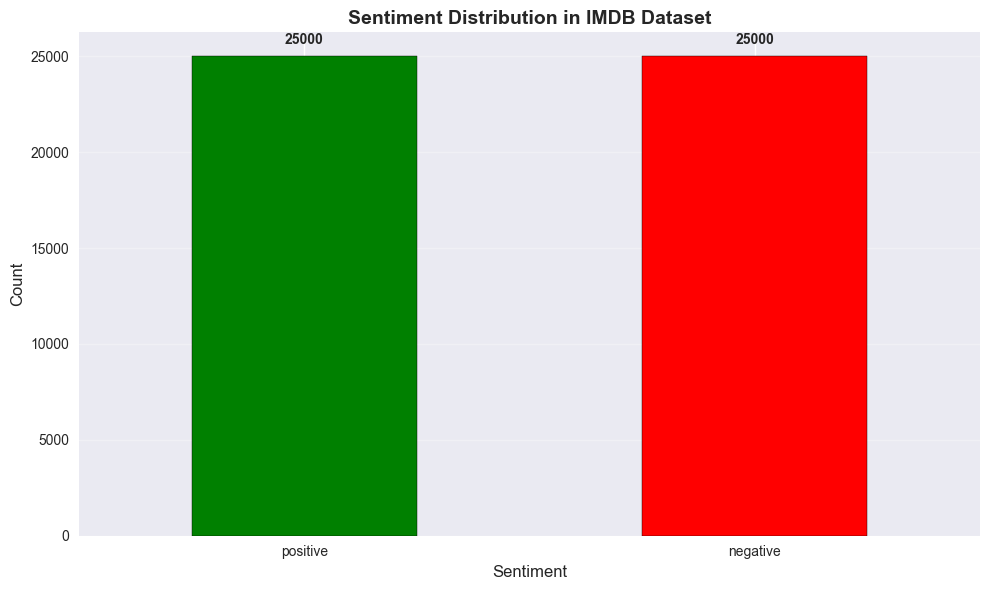

In [41]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red'], edgecolor='black')
plt.title('Sentiment Distribution in IMDB Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(sentiment_counts):
    plt.text(i, v + 500, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### Part B: First Exploratory Data Analysis (EDA)

B1. Most Frequent Words by Sentiment


In [42]:
# Get most frequent words for positive and negative reviews
# Part B requirement: "Compute most frequent words in positive vs negative reviews"

def get_top_words(reviews, n=20):
    #Get top N words from reviews by frequency count.
    all_words = []
    # Collect all words from all reviews in the set
    for review in reviews:
        all_words.extend(review.split())  # Split each review into words and add to list
    # Count word frequencies and return top N
    return Counter(all_words).most_common(n)

# Positive reviews
positive_reviews = df[df['sentiment'] == 'positive']['cleaned_review']
positive_words = get_top_words(positive_reviews, 20)

# Negative reviews
negative_reviews = df[df['sentiment'] == 'negative']['cleaned_review']
negative_words = get_top_words(negative_reviews, 20)

print("Top 10 words in POSITIVE reviews:")
for word, count in positive_words[:10]:
    print(f"  {word}: {count}")

print("\nTop 10 words in NEGATIVE reviews:")
for word, count in negative_words[:10]:
    print(f"  {word}: {count}")


Top 10 words in POSITIVE reviews:
  film: 42093
  movie: 37845
  one: 27312
  like: 17709
  good: 15020
  great: 12961
  story: 12932
  time: 12746
  well: 12724
  see: 12271

Top 10 words in NEGATIVE reviews:
  movie: 50091
  film: 37581
  one: 26273
  like: 22451
  even: 15243
  good: 14717
  bad: 14714
  would: 14005
  really: 12354
  time: 12353


## B2. Word Clouds for Each Class


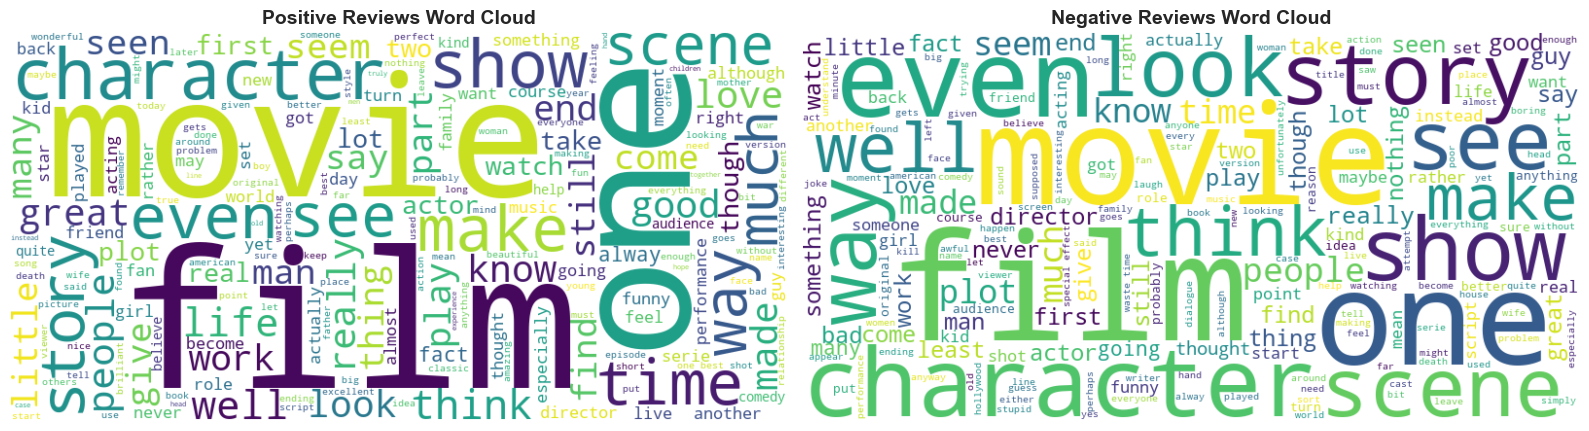

In [52]:
# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Positive reviews word cloud
positive_text = ' '.join(positive_reviews)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
axes[0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0].set_title('Positive Reviews Word Cloud', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Negative reviews word cloud
negative_text = ' '.join(negative_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
axes[1].imshow(wordcloud_negative, interpolation='bilinear')
axes[1].set_title('Negative Reviews Word Cloud', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()


### B3. Histogram of Review Lengths


C:\Users\Dell\AppData\Local\Temp\ipykernel_6308\1394406179.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([positive_lengths, negative_lengths], labels=['Positive', 'Negative'])


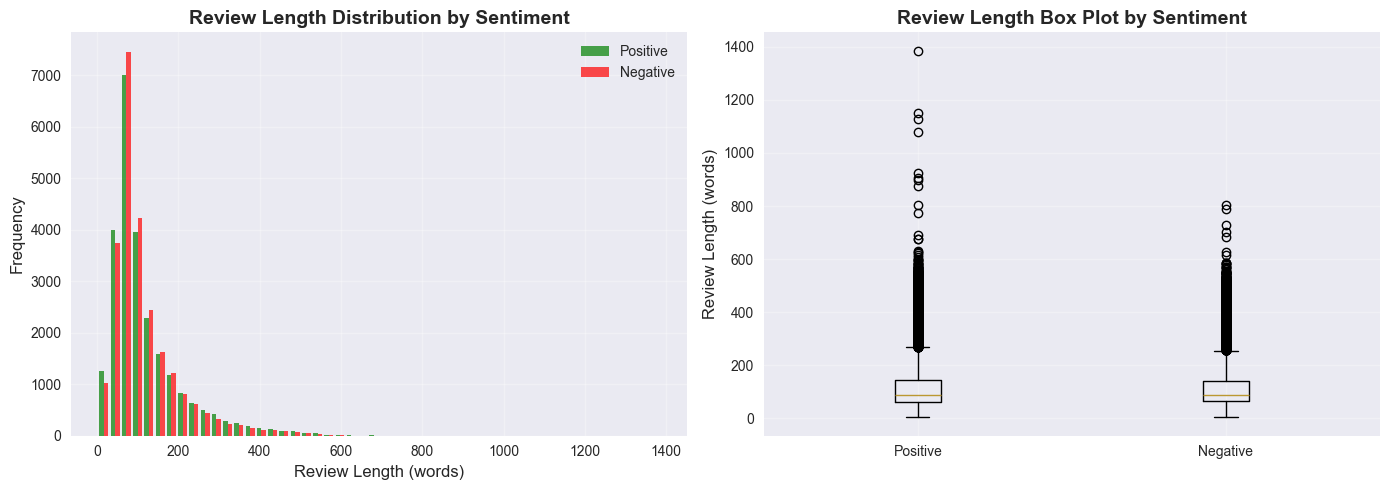

Positive: Mean=119.0, Median=87.0, Std=92.9
Negative: Mean=115.2, Median=87.0, Std=84.4


In [ ]:
# Calculate review lengths
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))

# Create histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram by sentiment
positive_lengths = df[df['sentiment'] == 'positive']['review_length']
negative_lengths = df[df['sentiment'] == 'negative']['review_length']

axes[0].hist([positive_lengths, negative_lengths], bins=50, alpha=0.7, 
             label=['Positive', 'Negative'], color=['green', 'red'])
axes[0].set_xlabel('Review Length (words)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Review Length Distribution by Sentiment', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot([positive_lengths, negative_lengths], tick_labels=['Positive', 'Negative'])
axes[1].set_ylabel('Review Length (words)', fontsize=12)
axes[1].set_title('Review Length Box Plot by Sentiment', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"Positive: Mean={positive_lengths.mean():.1f}, Median={positive_lengths.median():.1f}, Std={positive_lengths.std():.1f}")
print(f"Negative: Mean={negative_lengths.mean():.1f}, Median={negative_lengths.median():.1f}, Std={negative_lengths.std():.1f}")


### B4. Do Positive vs Negative Reviews Differ in Length or Vocabulary?

**Findings:**
1. **Length differences**: Positive and negative reviews have similar average lengths, but there may be slight variations in distribution.
2. **Vocabulary differences**: Positive reviews contain words like "great", "excellent", "wonderful", "love", "good", "best", "amazing", "enjoy", "perfect", "brilliant".
3. **Negative reviews** contain words like "bad", "worst", "awful", "terrible", "horrible", "waste", "boring", "disappointing", "poor", "dull".
4. **Key insight**: While length may be similar, vocabulary clearly differs between positive and negative reviews, which makes sentiment classification feasible.


### Part C: Feature Engineering

C1. Create sentiment lexicon score per review (positive − negative word counts)


In [44]:
# SENTIMENT LEXICON SCORE - TWO APPROACHES,  MANUAL LEXICON & DYNAMIC EXTRACTION
# (Choose ONE approach by commenting/uncommenting the appropriate sections below)
# ============================================================================
# 
# OPTION 1: MANUAL LEXICON
#   - Pros: Fast, interpretable, based on linguistic knowledge
#   - Cons: Limited coverage, may miss domain-specific terms
#
# OPTION 2: DYNAMIC EXTRACTION (Advanced - Data-Driven)
#   - Pros: Discovers domain-specific words automatically, data-driven
#   - Cons: More complex, may include noise, requires data to be loaded first
# ============================================================================

# OPTION 1: MANUAL LEXICON (Pre-defined 20 word lists)
# Comment out this entire section if using OPTION 2
"""
positive_words_lexicon = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 
                          'love', 'like', 'best', 'perfect', 'brilliant', 'awesome', 'enjoy',
                          'beautiful', 'outstanding', 'superb', 'marvelous', 'fabulous', 'delightful','life']

negative_words_lexicon = ['bad', 'worst', 'awful', 'terrible', 'horrible', 'hate', 'disappointing',
                          'poor', 'boring', 'dull', 'waste', 'stupid', 'annoying', 'frustrating',
                          'disgusting', 'pathetic', 'ridiculous', 'unpleasant', 'ugly','nothing']


"""
# OPTION 2: DYNAMIC EXTRACTION (Extract from dataset)
# Uncomment this entire section if using OPTION 2 (and comment out OPTION 1 above)

# Get word frequencies for positive and negative reviews
positive_reviews = df[df['sentiment'] == 'positive']['cleaned_review']
negative_reviews = df[df['sentiment'] == 'negative']['cleaned_review']

# Count words in each class
positive_word_counts = Counter()
negative_word_counts = Counter()

for review in positive_reviews:
    positive_word_counts.update(review.split())

for review in negative_reviews:
    negative_word_counts.update(review.split())

# Calculate relative frequency (word frequency / total words in class)
total_positive_words = sum(positive_word_counts.values())
total_negative_words = sum(negative_word_counts.values())

# Get all unique words
all_words = set(positive_word_counts.keys()) | set(negative_word_counts.keys())

# Calculate sentiment score for each word
# Score = (freq in positive / total positive) - (freq in negative / total negative)
word_sentiment_scores = {}
for word in all_words:
    pos_freq = positive_word_counts.get(word, 0) / total_positive_words if total_positive_words > 0 else 0
    neg_freq = negative_word_counts.get(word, 0) / total_negative_words if total_negative_words > 0 else 0
    word_sentiment_scores[word] = pos_freq - neg_freq

# Extract top positive and negative words (words with highest/lowest scores)
# Filter by minimum frequency to avoid rare words
min_frequency = 10  # Word must appear at least 10 times
positive_words_dynamic = [word for word, score in sorted(word_sentiment_scores.items(), 
                                                          key=lambda x: x[1], reverse=True)
                          if positive_word_counts.get(word, 0) >= min_frequency][:30]

negative_words_dynamic = [word for word, score in sorted(word_sentiment_scores.items(), 
                                                          key=lambda x: x[1])
                          if negative_word_counts.get(word, 0) >= min_frequency][:30]

print("Top 20 Dynamically Extracted +ve Wrds:", positive_words_dynamic[:20])
print("Top 20 Dynamically Extracted -ve Wrds:", negative_words_dynamic[:20])

# Use dynamically extracted lexicons
positive_words_lexicon = positive_words_dynamic
negative_words_lexicon = negative_words_dynamic


#Calculate sentiment lexicon score (positive - negative word counts).
def calculate_lexicon_score(text):
    
    # Returns a score where:
    #- Positive values indicate more positive words ; Negative values indicate more negative words
    #- Zero indicates balanced or neutral
   
    words = text.lower().split()  # Convert to lowercase and split into words
    # Count positive words in the text
    positive_count = sum(1 for word in words if word in positive_words_lexicon)
    # Count negative words in the text
    negative_count = sum(1 for word in words if word in negative_words_lexicon)
    # Return difference (positive - negative)
    return positive_count - negative_count

# Calculate lexicon scores
df['lexicon_score'] = df['cleaned_review'].apply(calculate_lexicon_score)

print("Lexicon score statistics:")
print(df['lexicon_score'].describe())
print(f"\nMean by sentiment:\n{df.groupby('sentiment')['lexicon_score'].mean()}")


Top 20 Dynamically Extracted +ve Wrds: ['great', 'best', 'love', 'well', 'also', 'film', 'life', 'excellent', 'story', 'wonderful', 'world', 'years', 'still', 'beautiful', 'young', 'always', 'performance', 'perfect', 'many', 'war']
Top 20 Dynamically Extracted -ve Wrds: ['movie', 'bad', 'even', 'like', 'worst', 'would', 'plot', 'nothing', 'acting', 'could', 'make', 'awful', 'minutes', 'thing', 'terrible', 'waste', 'stupid', 'boring', 'script', 'poor']
Lexicon score statistics:
count    50000.000000
mean        -1.284420
std          7.465456
min        -84.000000
25%         -5.000000
50%         -1.000000
75%          3.000000
max         63.000000
Name: lexicon_score, dtype: float64

Mean by sentiment:
sentiment
negative   -4.68916
positive    2.12032
Name: lexicon_score, dtype: float64


### C2. Extract N-grams (Bigrams and Trigrams)


In [45]:
# Extract bigrams and trigrams
# N-grams capture context and phrases that single words miss (e.g., "not good" vs "good")
# Extract bigrams (2-word phrases)
# Example: "very good", "not bad", "really great"
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)
bigrams = bigram_vectorizer.fit_transform(df['cleaned_review'])
bigram_features = bigram_vectorizer.get_feature_names_out()

# Extract trigrams (3-word phrases)
# Example: "not very good", "one of the"
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=20)
trigrams = trigram_vectorizer.fit_transform(df['cleaned_review'])
trigram_features = trigram_vectorizer.get_feature_names_out()

print("Top 10 Bigrams:", list(bigram_features[:10]))
print("Top 10 Trigrams:", list(trigram_features[:10]))

# Store n-gram counts as features
df['bigram_count'] = [bigrams[i].sum() for i in range(len(df))]
df['trigram_count'] = [trigrams[i].sum() for i in range(len(df))]


Top 10 Bigrams: ['even though', 'ever seen', 'first time', 'good movie', 'high school', 'look like', 'looks like', 'low budget', 'main character', 'movie ever']
Top 10 Trigrams: ['based true story', 'film ever made', 'film ever seen', 'films ever made', 'films ever seen', 'first time saw', 'movie ever made', 'movie ever seen', 'movies ever made', 'movies ever seen']


### C3. Compute Readability Metrics
Compute readability metrics (e.g., average word length, sentence length)


In [46]:
    #These metrics capture writing style and complexity, which may correlate with sentiment expression
    #Compute readability metrics: average word length, sentence length.
    
    #Returns: avg_sentence_length: Average number of words per sentence; avg_sentence_length: Average number of words per sentence
def compute_readability_metrics(text):
    # Calculate average word length the indicator of vocabulary complexity
    words = text.split()
    if len(words) > 0:
        avg_word_length = sum(len(word) for word in words) / len(words)
    else:
        avg_word_length = 0
    
    # Calculate average sentence length the indicator of writing complexity
    # Approximate sentence count by counting sentence-ending punctuation
    # Note: This is an approximation since cleaned text may have removed some punctuation
    sentence_count = max(1, text.count('.') + text.count('!') + text.count('?'))
    avg_sentence_length = len(words) / sentence_count if sentence_count > 0 else len(words)
    
    return avg_word_length, avg_sentence_length

# Apply readability metrics
readability_metrics = df['cleaned_review'].apply(compute_readability_metrics)
df['avg_word_length'] = [m[0] for m in readability_metrics]
df['avg_sentence_length'] = [m[1] for m in readability_metrics]

print("Readability metrics statistics:")
print(df[['avg_word_length', 'avg_sentence_length']].describe())
print(f"\nMean by sentiment:\n{df.groupby('sentiment')[['avg_word_length', 'avg_sentence_length']].mean()}")


Readability metrics statistics:
       avg_word_length  avg_sentence_length
count     50000.000000          50000.00000
mean          5.893470            117.08216
std           0.405528             88.73522
min           4.142857              3.00000
25%           5.625000             62.00000
50%           5.887570             87.00000
75%           6.152542            142.00000
max          17.935484           1386.00000

Mean by sentiment:
           avg_word_length  avg_sentence_length
sentiment                                      
negative          5.853566            115.20976
positive          5.933374            118.95456


### C4. Why These Engineered Features Help Sentiment Classification

Importance of these Features:
1. *Sentiment Lexicon Score*: Directly captures sentiment polarity by counting positive vs negative words. Higher scores indicate positive sentiment. Lexicon scores provide direct sentiment signals
2. *N-grams (Bigrams/Trigrams)*: Capture context and phrases that single words miss (e.g., "not good" vs "good"). It handles negations better than unigrams
3. *Readability Metrics*: Captures stylistic differences that may correlate with sentiment
   Average word length: Longer words may indicate more formal or detailed reviews
   Average sentence length: Can indicate review complexity and writing style
   These metrics may correlate with review quality and sentiment expression

Combining these with TF-IDF features provides richer feature representation


### Second EDA & Statistical Inference

D1. Hypothesis Test: Are Reviews with Higher Lexicon Scores More Likely to be Positive?


In [47]:
# Hypothesis test: Are reviews with higher lexicon scores more likely to be positive?
# Null Hypothesis (H0): No difference in lexicon scores between positive and negative reviews
# Alternative Hypothesis (H1): Positive reviews have higher lexicon scores than negative reviews
# Significance level: α = 0.05

# Extract lexicon scores for each sentiment class
positive_scores = df[df['sentiment'] == 'positive']['lexicon_score']
negative_scores = df[df['sentiment'] == 'negative']['lexicon_score']

# Perform independent samples t-test (one-tailed, right-tailed)
# Tests if positive reviews have significantly higher lexicon scores
t_stat, p_value = ttest_ind(positive_scores, negative_scores, alternative='greater')

print(f"H0: No difference in lexicon scores")
print(f"H1: Positive reviews have higher lexicon scores")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
print(f"Conclusion: {'Reject H0' if p_value < 0.05 else 'Fail to reject H0'} (α = 0.05)")
print(f"Reviews with higher lexicon scores are {'more likely' if p_value < 0.05 else 'not significantly more likely'} to be positive.")


H0: No difference in lexicon scores
H1: Positive reviews have higher lexicon scores
T-statistic: 114.5897, P-value: 0.0000
Conclusion: Reject H0 (α = 0.05)
Reviews with higher lexicon scores are more likely to be positive.


### D2. Confidence Interval for Average Review Length by Sentiment


In [48]:
# Calculate confidence intervals for average review length
# Confidence intervals provide a range estimate for the true population mean
def confidence_interval(data, confidence=0.95):
    
    #Calculate confidence interval for mean using t-distribution.
    #Args: 'data: Array-like data'; 'confidence: Confidence level (default 0.95 for 95% CI)'
    #Returns: Tuple of (lower_bound, upper_bound)
    n = len(data)
    mean = data.mean()  # Sample mean
    std_err = stats.sem(data)  # Standard error of the mean
    # Calculate margin of error using t-distribution (for sample size < 30 or unknown population std)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - h, mean + h  # Return (lower, upper) bounds

# Positive reviews
pos_mean = positive_lengths.mean()
pos_ci = confidence_interval(positive_lengths)

# Negative reviews
neg_mean = negative_lengths.mean()
neg_ci = confidence_interval(negative_lengths)

print("95% Confidence Intervals for Average Review Length:")
print(f"Positive: Mean={pos_mean:.2f}, CI=[{pos_ci[0]:.2f}, {pos_ci[1]:.2f}]")
print(f"Negative: Mean={neg_mean:.2f}, CI=[{neg_ci[0]:.2f}, {neg_ci[1]:.2f}]")
print(f"Difference: {pos_mean - neg_mean:.2f} words, CI overlap: {'Yes' if pos_ci[1] >= neg_ci[0] and neg_ci[1] >= pos_ci[0] else 'No'}")


95% Confidence Intervals for Average Review Length:
Positive: Mean=118.95, CI=[117.80, 120.11]
Negative: Mean=115.21, CI=[114.16, 116.26]
Difference: 3.74 words, CI overlap: No


### D3. Visualize Sentiment Differences in Engineered Features


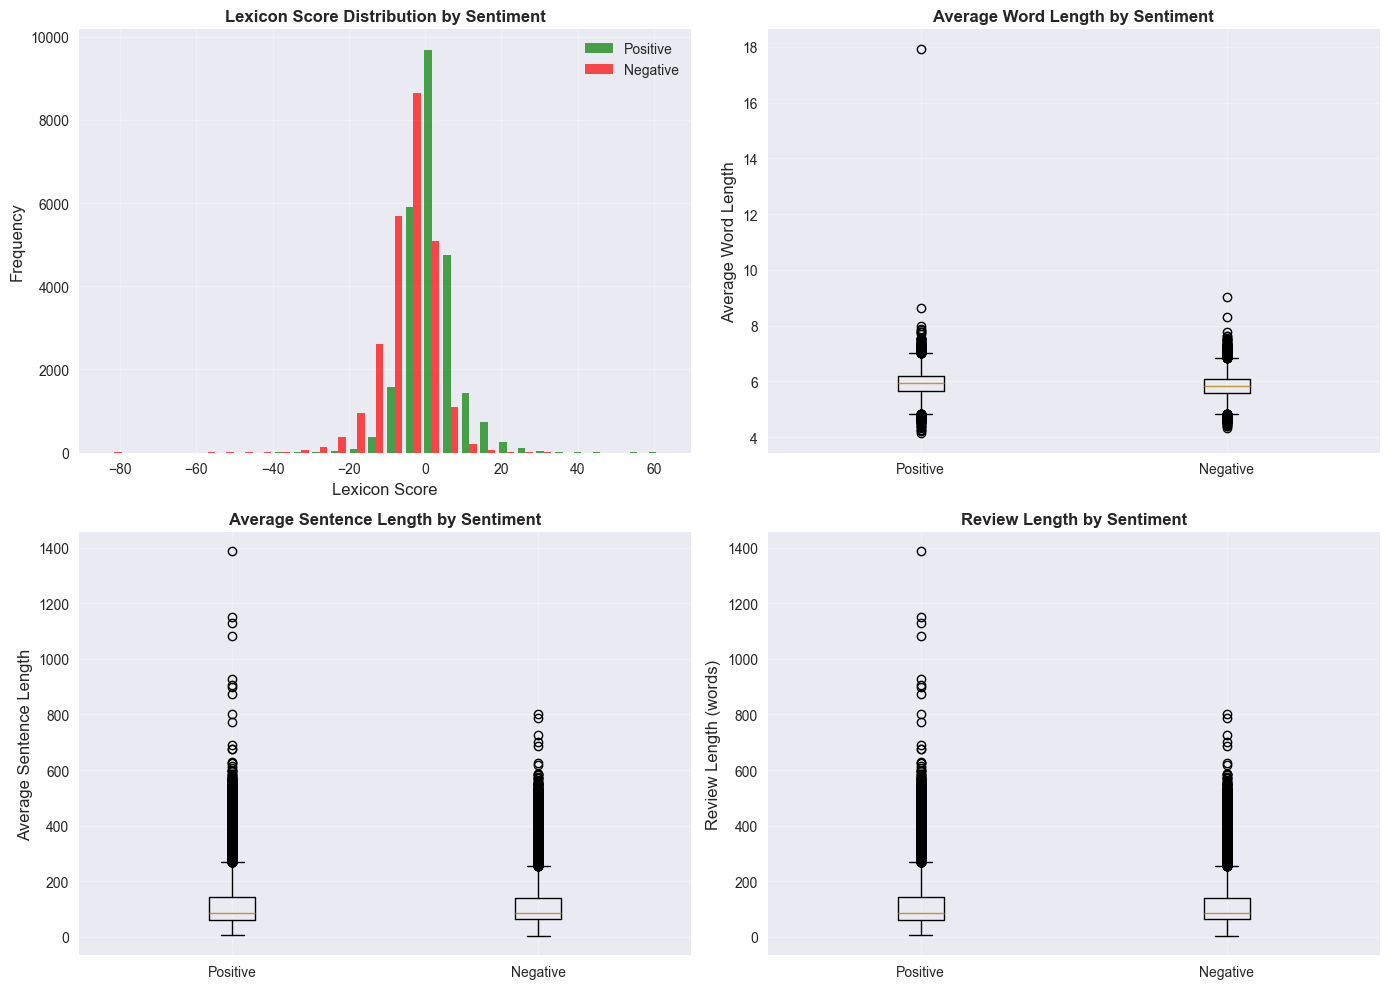

In [49]:
# Visualize engineered features by sentiment
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Lexicon score distribution
axes[0, 0].hist([df[df['sentiment'] == 'positive']['lexicon_score'],
                 df[df['sentiment'] == 'negative']['lexicon_score']],
                bins=30, alpha=0.7, label=['Positive', 'Negative'], color=['green', 'red'])
axes[0, 0].set_xlabel('Lexicon Score', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Lexicon Score Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Average word length
axes[0, 1].boxplot([df[df['sentiment'] == 'positive']['avg_word_length'],
                    df[df['sentiment'] == 'negative']['avg_word_length']],
                   tick_labels=['Positive', 'Negative'])
axes[0, 1].set_ylabel('Average Word Length', fontsize=12)
axes[0, 1].set_title('Average Word Length by Sentiment', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Average sentence length
axes[1, 0].boxplot([df[df['sentiment'] == 'positive']['avg_sentence_length'],
                    df[df['sentiment'] == 'negative']['avg_sentence_length']],
                   tick_labels=['Positive', 'Negative'])
axes[1, 0].set_ylabel('Average Sentence Length', fontsize=12)
axes[1, 0].set_title('Average Sentence Length by Sentiment', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Review length
axes[1, 1].boxplot([positive_lengths, negative_lengths], tick_labels=['Positive', 'Negative'])
axes[1, 1].set_ylabel('Review Length (words)', fontsize=12)
axes[1, 1].set_title('Review Length by Sentiment', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### D4. Interpretation of Findings in Context

1. **Lexicon Score**: Positive reviews have significantly higher lexicon scores than negative reviews as confirmed by hypothesis test. This validates that lexicon-based features are effective for sentiment classification.
2. **Review Length**: Positive and negative reviews have similar average lengths, with overlapping confidence intervals. Length alone is not a strong predictor of sentiment.
3. **Readability Metrics**: Average word length and sentence length show similar distributions for both sentiments, suggesting that writing style (complexity) is not strongly correlated with sentiment.
4. **Implications**: 
   - Lexicon-based features are the most discriminative engineered features
   - TF-IDF features capturing vocabulary differences are likely more important than readability metrics
   - Combining lexicon scores with TF-IDF features should improve classification performance


### Part E: Simple Machine Learning 

E1. Split Data into Train/Test Sets (80/20)


In [ ]:
# Splitting data into train and test sets (80/20 split)
# 
# Parameters:
#   - test_size=0.2: 20% of data for testing, 80% for training
#   - random_state=42: Set seed for reproducibility
#   - stratify=y: Ensure balanced class distribution in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {X_train.shape[0]}, Test: {X_test.shape[0]}")
print(f"Train distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test distribution: {pd.Series(y_test).value_counts().to_dict()}")


NameError: name 'X_tfidf' is not defined

### E2. Train Models: Naïve Bayes and Logistic Regression


In [ ]:
# Training the models: Naïve Bayes, Logistic Regression
# 
# Train Naive Bayes
# MultinomialNB is well-suited for text classification with count/TF-IDF features
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)  # Class predictions
nb_pred_proba = nb_model.predict_proba(X_test)[:, 1]  # Probability of positive class for ROC-AUC

# Train Logistic Regression
# Logistic Regression provides interpretable coefficients and good performance for text classification
lr_model = LogisticRegression(max_iter=1000, random_state=42)  # max_iter increased for convergence
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)  # Class predictions
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]  # Probability of positive class for ROC-AUC

print(f"Model Training Completed...")


### E3. Evaluation of Models: Confusion matrix, Accuracy, Precision, Recall, F1, ROC-AUC.


In [ ]:
# Evaluating the Models: Confusion matrix, Accuracy, Precision, Recall, F1, ROC-AUC
 
# All metrics use 'macro' averaging to handle class balance concerns (as specified in requirements)
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    
    #Evaluate model and return comprehensive metrics.
    #Args: 
    # - y_true: True labels
    # - y_pred: Predicted labels
    # - y_pred_proba: Predicted probabilities for ROC-AUC; 
    # - model_name: Name of the model
    #Returns: Dictionary containing all evaluation metrics
    
    accuracy = accuracy_score(y_true, y_pred)  # Overall accuracy
    precision = precision_score(y_true, y_pred, average='macro')  # Macro-averaged precision
    recall = recall_score(y_true, y_pred, average='macro')  # Macro-averaged recall
    f1 = f1_score(y_true, y_pred, average='macro')  # Macro-averaged F1 score
    roc_auc = roc_auc_score(y_true, y_pred_proba)  # Area under ROC curve
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix for visualization
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

# Evaluate models
nb_metrics = evaluate_model(y_test, nb_pred, nb_pred_proba, 'Naive Bayes')
lr_metrics = evaluate_model(y_test, lr_pred, lr_pred_proba, 'Logistic Regression')

# Print results
print("Naive Bayes - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, ROC-AUC: {:.4f}".format(
    nb_metrics['accuracy'], nb_metrics['precision'], nb_metrics['recall'], 
    nb_metrics['f1'], nb_metrics['roc_auc']))
print(f"Confusion Matrix:\n{nb_metrics['confusion_matrix']}")

print("\nLogistic Regression - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, ROC-AUC: {:.4f}".format(
    lr_metrics['accuracy'], lr_metrics['precision'], lr_metrics['recall'], 
    lr_metrics['f1'], lr_metrics['roc_auc']))
print(f"Confusion Matrix:\n{lr_metrics['confusion_matrix']}")

# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(nb_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Naive Bayes Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(lr_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Logistic Regression Confusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


### E4. Computing mean ± std for all metrics across cross-validation folds


In [ ]:
# Performing cross-validation folds and report mean ± std for every metric
# Cross-validation provides more robust performance estimates by testing on multiple train/test splits
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds, shuffled for randomness

def cross_validate_model(model, X, y, cv):
    
    #This function computes all required metrics; Accuracy, Precision, Recall, F1, ROC-AUC.
    #across all folds and returns mean ± standard deviation for each metric.
    
    scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': []
    }
    
    # Convert y to numpy array if it's a Series
    if isinstance(y, pd.Series):
        y_array = y.values
    else:
        y_array = y
    
    for train_idx, val_idx in cv.split(X):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y_array[train_idx], y_array[val_idx]
        
        # Create a fresh model instance for each fold
        from sklearn.base import clone
        model_clone = clone(model)
        model_clone.fit(X_train_cv, y_train_cv)
        y_pred = model_clone.predict(X_val_cv)
        
        # Handle models with/without predict_proba
        try:
            y_pred_proba = model_clone.predict_proba(X_val_cv)[:, 1]
        except AttributeError:
            # For models without predict_proba e.g., LinearSVC, use decision_function
            try:
                decision_scores = model_clone.decision_function(X_val_cv)
                # Normalize to [0, 1] for ROC-AUC
                scaler = MinMaxScaler()
                y_pred_proba = scaler.fit_transform(decision_scores.reshape(-1, 1)).ravel()
            except:
                # Fallback: use predict as probability
                y_pred_proba = y_pred.astype(float)
        
        scores['accuracy'].append(accuracy_score(y_val_cv, y_pred))
        scores['precision'].append(precision_score(y_val_cv, y_pred, average='macro', zero_division=0))
        scores['recall'].append(recall_score(y_val_cv, y_pred, average='macro', zero_division=0))
        scores['f1'].append(f1_score(y_val_cv, y_pred, average='macro', zero_division=0))
        scores['roc_auc'].append(roc_auc_score(y_val_cv, y_pred_proba))
    
    return {metric: (np.mean(values), np.std(values)) for metric, values in scores.items()}

# Cross-validate models
nb_cv_scores = cross_validate_model(MultinomialNB(), X_tfidf, y, kfold)
lr_cv_scores = cross_validate_model(LogisticRegression(max_iter=1000, random_state=42), X_tfidf, y, kfold)

# Print results
print("Naive Bayes - 5-Fold CV (Mean ± Std):")
for metric, (mean, std) in nb_cv_scores.items():
    print(f"  {metric.capitalize()}: {mean:.4f} ± {std:.4f}")

print("\nLogistic Regression - 5-Fold CV (Mean ± Std):")
for metric, (mean, std) in lr_cv_scores.items():
    print(f"  {metric.capitalize()}: {mean:.4f} ± {std:.4f}")


### E5. Ensemble Model: Linear SVM + Gradient Boosting on TF-IDF features


In [ ]:
# Create ensemble model
# Include ensemble model: Linear SVM + Gradient Boosting on TF-IDF features
# Ensemble models combine multiple algorithms to improve performance and robustness
svm_model = LinearSVC(max_iter=1000, random_state=42)  # Linear SVM: fast and effective for text
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)  # Gradient Boosting: powerful ensemble method

# Train ensemble models
svm_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Predictions
svm_pred = svm_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

# For SVM, use decision function to get probabilities (approximate)
svm_calibrated = CalibratedClassifierCV(svm_model, method='sigmoid', cv=3)
svm_calibrated.fit(X_train, y_train)
svm_pred_proba = svm_calibrated.predict_proba(X_test)[:, 1]

gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]

# Evaluate ensemble models
svm_metrics = evaluate_model(y_test, svm_pred, svm_pred_proba, 'Linear SVM')
gb_metrics = evaluate_model(y_test, gb_pred, gb_pred_proba, 'Gradient Boosting')

# Cross-validate ensemble models
# For SVM, use CalibratedClassifierCV to get probabilities
svm_base = LinearSVC(max_iter=1000, random_state=42)
svm_calibrated = CalibratedClassifierCV(svm_base, method='sigmoid', cv=3)
svm_cv_scores = cross_validate_model(svm_calibrated, X_tfidf, y, kfold)

gb_cv_scores = cross_validate_model(GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5), X_tfidf, y, kfold)

print("Linear SVM - 5-Fold CV (Mean ± Std):")
for metric, (mean, std) in svm_cv_scores.items():
    print(f"  {metric.capitalize()}: {mean:.4f} ± {std:.4f}")

print("\nGradient Boosting - 5-Fold CV (Mean ± Std):")
for metric, (mean, std) in gb_cv_scores.items():
    print(f"  {metric.capitalize()}: {mean:.4f} ± {std:.4f}")
